In [1]:
import numpy as np
from scipy import stats
from scipy.interpolate import griddata

import einops
import concurrent.futures
import pickle


import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import niapy
from niapy.problems import ExpandedSchaffer as TestFunction

import hiposa
import hiposa.poisson_tiler

import os

In [2]:
help(TestFunction)

Help on class ExpandedSchaffer in module niapy.problems.schaffer:

class ExpandedSchaffer(niapy.problems.problem.Problem)
 |  ExpandedSchaffer(dimension=4, lower=-100.0, upper=100.0, *args, **kwargs)
 |  
 |  Implementations of Expanded Schaffer functions.
 |  
 |  Date: 2018
 |  
 |  Author: Klemen Berkovič
 |  
 |  License: MIT
 |  
 |  Function:
 |      **Expanded Schaffer Function**
 |  
 |      .. math::
 |  
 |         f(\textbf{x}) = g(x_D, x_1) + \sum_{i=2}^D g(x_{i - 1}, x_i)
 |  
 |         g(x, y) = 0.5 + \frac{\sin \left(\sqrt{x^2 + y^2} \right)^2 - 0.5}{\left( 1 + 0.001 (x^2 + y^2) \right)}^2`
 |  
 |  **Input domain:**
 |      The function can be defined on any input domain but it is usually
 |      evaluated on the hypercube :math:`x_i ∈ [-100, 100]`, for all :math:`i = 1, 2,..., D`.
 |  
 |  **Global minimum:** :math:`f(x^*) = 0`, at :math:`x_i^* = 0`
 |  
 |  LaTeX formats:
 |      Inline:
 |          $f(\textbf{x}) = g(x_D, x_1) + \sum_{i=2}^D g(x_{i - 1}, x_i) \\ g(x

In [3]:
lower=-10
upper=10
f = TestFunction(dimension=2, upper=upper, lower=lower)

In [4]:
Ngrid = 100j
grid_x, grid_y = np.mgrid[lower:upper:Ngrid,lower:upper:Ngrid,]
f_gt = np.zeros_like(grid_x)
for i in range(100):
    for j in range(100):
        f_gt[i,j]=f( np.array((grid_x[i,j], grid_y[i,j])).flatten() )
        

In [12]:
def generate_poisson_points(i, lower, upper, scales):
    # Each worker function gets its own seed based on the iteration
    np.random.seed(42 + i)  # Optional but ensures reproducibility with different seeds
    
    pTiler = hiposa.poisson_tiler.PoissonTiler(tile_size=scales[0]*1, spacings=scales)
    xy, levels = pTiler.get_points_in_region([[lower, upper], [lower, upper]])
    print(f"Worker {i}: Generated {len(xy)} points")
    return (xy, levels)

scales = (upper-lower)/10 / (np.sqrt(2)**np.arange(0,8,1))
n_sets = 1

# Parallel execution using ThreadPoolExecutor
xyls = []
with concurrent.futures.ThreadPoolExecutor(max_workers=min(n_sets, 32)) as executor:
    # Submit all tasks
    futures = [executor.submit(generate_poisson_points, i, lower, upper, scales) 
               for i in range(n_sets)]
    
    # Collect results as they complete
    for future in concurrent.futures.as_completed(futures):
        xyls.append(future.result())

# Print total points generated
total_points = sum(len(xy) for xy, _ in xyls)
print(f"Total points generated: {total_points}")


Initializing PoissonTiler:
Requested tile size: 2.0
Actual tile size: 4.0 (minimum required: 4.0)
Spacings: [2.         1.41421356 1.         0.70710678 0.5        0.35355339
 0.25       0.1767767 ]
Dimensions: 2
Tile domain: [(0, 4.0), (0, 4.0)]

Generating base tile...

Generating level 0 with spacing 2.0
Level 0: Generated 1 points

Generating level 1 with spacing 1.414213562373095
[[3.0585217  1.94880854]]
Level 1: Generated 4 points

Generating level 2 with spacing 0.9999999999999998
[[3.0585217  1.94880854]
 [1.23370749 2.73304088]
 [2.43432483 0.45151587]
 [3.81034518 3.29710861]
 [1.05985994 0.95693175]]
Level 2: Generated 6 points

Generating level 3 with spacing 0.7071067811865474
[[3.0585217  1.94880854]
 [1.23370749 2.73304088]
 [2.43432483 0.45151587]
 [3.81034518 3.29710861]
 [1.05985994 0.95693175]
 [0.04371218 2.19303588]
 [3.93785428 0.98391614]
 [0.81549323 3.67885622]
 [2.03195809 1.97203074]
 [1.88391872 3.6144081 ]
 [2.79048828 3.00480176]]
Level 3: Generated 9 po

Level 7: Generated 159 points

Base tile complete with 325 total points
Worker 0: Generated 8125 points
Total points generated: 8125


(8125,)
0.7191512747793923


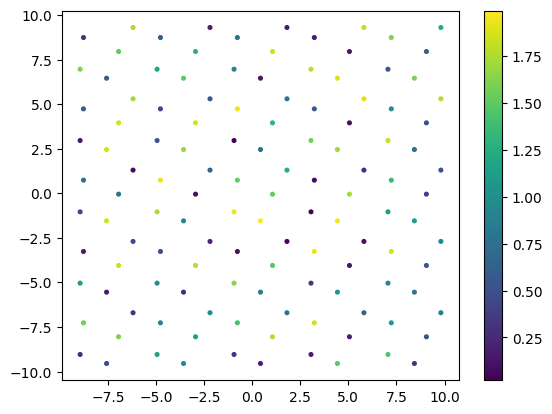

(8125,)
0.5660925323086996


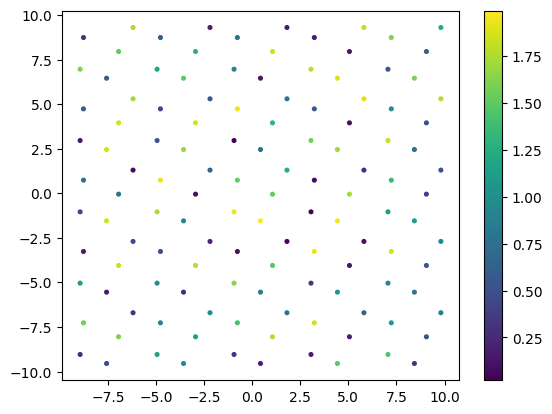

(8125,)
0.4521097024222596


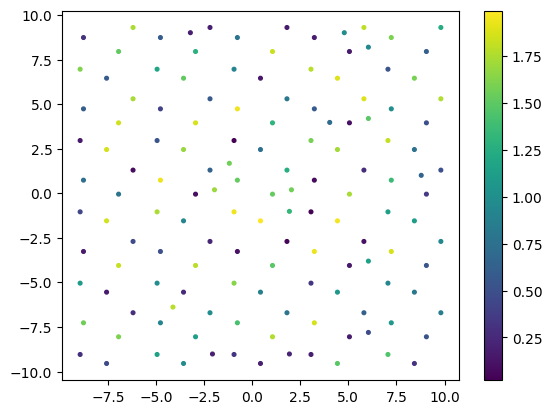

(8125,)
0.3586879891910202


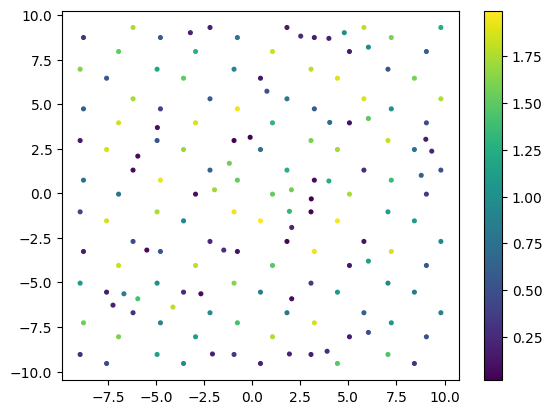

(8125,)
0.2881693366698335


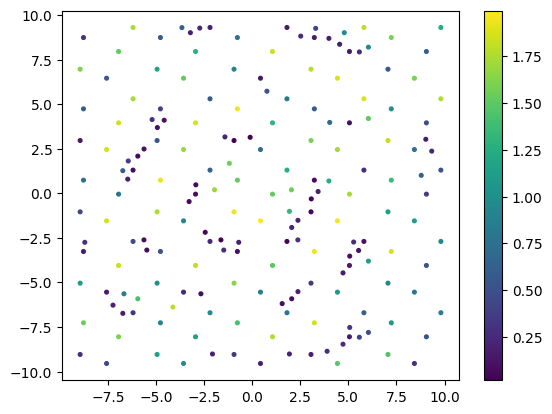

(8125,)
0.23075269391050465


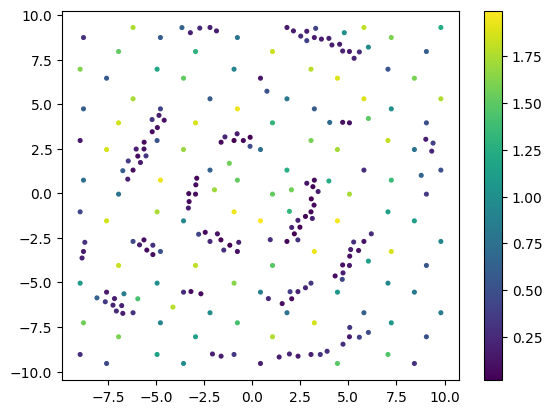

(8125,)
0.17919254301915724


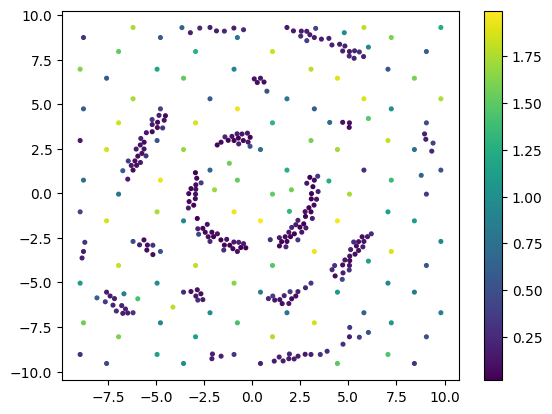

(8125,)
0.14009989923436347


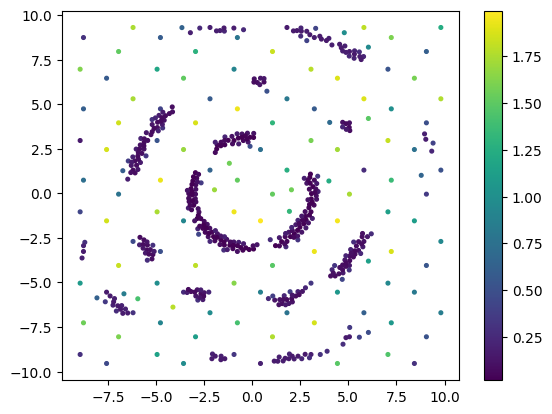

(8125,)


In [21]:
xy = xyls[0][0]
levels = xyls[0][1]
index_array = np.arange(len(levels))

sel = levels <= 1
print(sel.shape)
for level in range(1, 9): 
    these_xy = xy[sel]
    f_hiposa = []
    for x_hiposa in these_xy:
        f_hiposa.append( f(x_hiposa) )
    f_hiposa = np.array(f_hiposa)
    if level==1:
        THRESHOLD = np.percentile(f_hiposa, 50.0)        
    THRESHOLD = 0.25*np.percentile(f_hiposa, 5.0)+0.75*THRESHOLD
    print(THRESHOLD)
    
    plt.scatter(these_xy[:,0], these_xy[:,1], c = f_hiposa, s=7)
    plt.colorbar()
    plt.show()
        
    grid_hiposa = griddata(these_xy, f_hiposa, (grid_x, grid_y), method='cubic')
    sel_2 = levels==level
    next_xy = xy[sel_2]
    sel_2 = index_array[sel_2]
    for s, this_next_one in zip(sel_2,next_xy):
        tx,ty = this_next_one
        d = np.sqrt( (grid_x-tx)**2 + (grid_y-ty)**2 )
        indx = np.argmin(d)
        value =  grid_hiposa[ np.unravel_index(indx, (100,100))] 
        if value < THRESHOLD:
            sel[s]=True
    print(sel.shape)
        
    
    
    
    
  

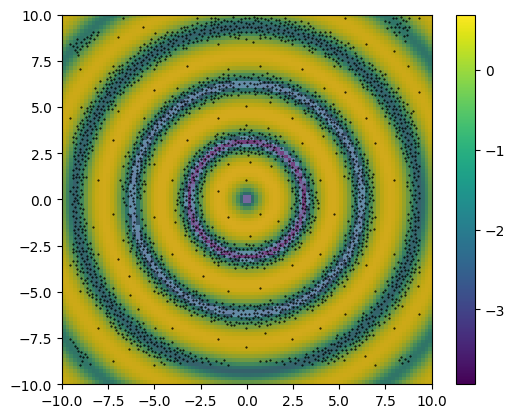

In [18]:
TT = np.percentile(f_gt.flatten(), 5.0)
plt.imshow(np.log(f_gt), origin="lower",  extent=(lower,upper,lower,upper))
plt.colorbar()
plt.imshow(f_gt> TT, alpha=0.26, extent=(lower,upper,lower,upper), cmap="Reds")
plt.scatter(these_xy[:,1], these_xy[:,0], c = "black", s=.25)
plt.show()

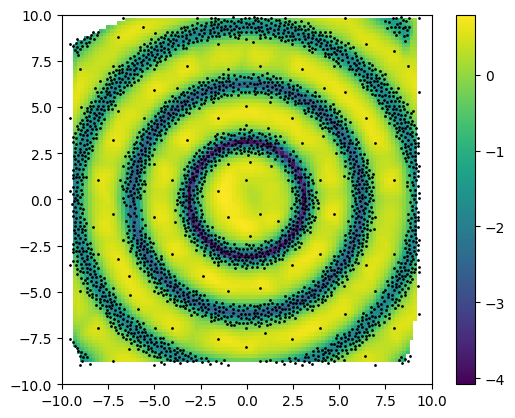

In [19]:
TT = np.percentile(f_gt.flatten(), 20.0)
plt.imshow(np.log(np.abs(grid_hiposa)), origin="lower",  extent=(lower,upper,lower,upper))
plt.colorbar()
#plt.imshow(f_gt> TT, alpha=0.26, extent=(lower,upper,lower,upper), cmap="Reds")
plt.scatter(these_xy[:,1], these_xy[:,0], c = "black", s=1)
plt.show()

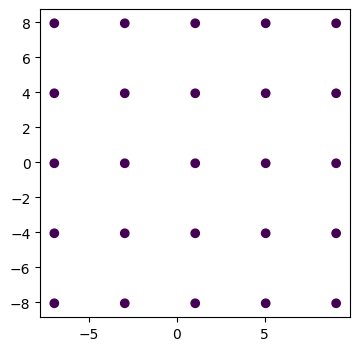

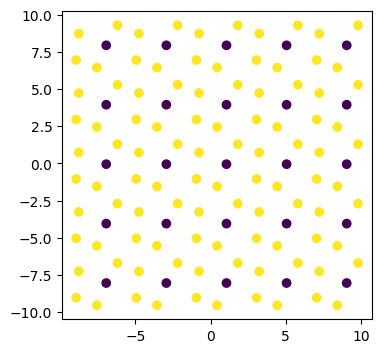

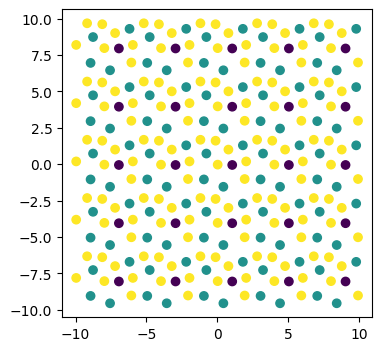

In [20]:
for ii in range(3):
    ss = levels <=ii
    plt.figure(figsize=(4,4))
    plt.scatter(xy[ss,0], xy[ss,1], c=levels[ss])
    plt.show()